In [1]:
from os import sys
sys.path.append("/meshAfterParty/")

In [2]:
from importlib import reload

import neuron_utils as nru

import neuron

import neuron_visualizations as nviz

import time

import datajoint_utils as du

import time

INFO - 2020-11-30 03:30:36,387 - settings - Setting database.host to at-database.ad.bcm.edu
INFO - 2020-11-30 03:30:36,388 - settings - Setting database.user to celiib
INFO - 2020-11-30 03:30:36,389 - settings - Setting database.password to newceliipass
INFO - 2020-11-30 03:30:36,401 - settings - Setting stores to {'minnie65': {'protocol': 'file', 'location': '/mnt/dj-stor01/platinum/minnie65', 'stage': '/mnt/dj-stor01/platinum/minnie65'}, 'meshes': {'protocol': 'file', 'location': '/mnt/dj-stor01/platinum/minnie65/02/meshes', 'stage': '/mnt/dj-stor01/platinum/minnie65/02/meshes'}, 'decimated_meshes': {'protocol': 'file', 'location': '/mnt/dj-stor01/platinum/minnie65/02/decimated_meshes', 'stage': '/mnt/dj-stor01/platinum/minnie65/02/decimated_meshes'}, 'skeletons': {'protocol': 'file', 'location': '/mnt/dj-stor01/platinum/minnie65/02/skeletons'}}
INFO - 2020-11-30 03:30:36,402 - settings - Setting enable_python_native_blobs to True
INFO - 2020-11-30 03:30:36,413 - connection - Connect

Connecting celiib@at-database.ad.bcm.edu:3306


INFO - 2020-11-30 03:30:36,611 - settings - Setting enable_python_native_blobs to True


In [3]:
minnie,schema = du.configure_minnie_vm()

INFO - 2020-11-30 03:30:36,628 - settings - Setting enable_python_native_blobs to True
INFO - 2020-11-30 03:30:36,820 - settings - Setting enable_python_native_blobs to True


# Getting the soma data and distanes

In [4]:
soma_segment_id,soma_x,soma_y,soma_z = (minnie.BaylorSegmentCentroid & minnie.AutoProofreadLabels.proj() & "multiplicity=1").fetch("segment_id",
                                                                                                                "centroid_x",
                                                                                                               "centroid_y",
                                                                                                               "centroid_z")

In [5]:
soma_segment_id.shape

(24842,)

In [ ]:
# Investigating the multi somas
#minnie.BaylorSegmentCentroid & "decimation_ratio=0.25" & minnie.AutoProofreadLabels.proj() & "multiplicity>1"# & (minnie.Decomposition() & "n_somas = 1").proj()

In [6]:
import numpy as np
soma_centers = np.vstack([soma_x,soma_y,soma_z]).T

# #visualizing the somas
# import neuron_visualizations as nviz
# nviz.plot_objects(scatters=[soma_centers])

# get the distances of the somas

In [7]:
import numpy_utils as nu

# Loading the data and taking a subgraph 

In [8]:
import networkx as nx
import networkx_utils as xu
xu = reload(xu)

# Doing the No Proofreading

In [9]:
no_proofread_graph = xu.unpickle_graph("./no_proofread_25k.pkl")
connectivity_ids = np.array(list(no_proofread_graph.nodes()))
connectivity_ids.shape

(24264,)

In [10]:
same_ids,x_ind,_ = np.intersect1d(soma_segment_id,connectivity_ids,return_indices=True)
filtered_soma_ids = soma_segment_id[x_ind]
filtered_soma_centers = soma_centers[x_ind]
filtered_soma_centers.shape

(24174, 3)

In [11]:
no_proofread_graph_filtered = no_proofread_graph.subgraph(filtered_soma_ids)
len(no_proofread_graph_filtered.nodes())

24174

In [12]:
seg_id_to_center_dict = dict([(k,sm_center.astype("float")) for k,sm_center in zip(filtered_soma_ids,filtered_soma_centers)])

In [13]:
"""
Pseudocode: 
For all of the edges
1) Get the linalg of the difference in soma centers for the 2
2) Add to the list

"""

total_distance_time = time.time()

total_distances = np.array([np.linalg.norm(seg_id_to_center_dict[pre] - seg_id_to_center_dict[post])
                  for pre,post in no_proofread_graph_filtered.edges()])

print(f"Total time for computing distances = {time.time() - total_distance_time}")

Total time for computing distances = 36.34931683540344


In [14]:
#removing the self loops
total_distances_no_self_loops = total_distances[total_distances != 0]
total_distances_no_self_loops

array([16561.70459222, 43811.36167708, 43811.36167708, ...,
        5303.42832515, 25732.94796559, 10724.85617619])

In [15]:
total_distances_no_self_loops.shape

(1806228,)

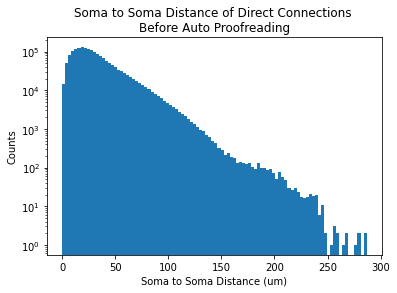

In [36]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots(1,1)
ax.hist(total_distances_no_self_loops/1000,bins=100,density=False)
ax.set_title("Soma to Soma Distance of Direct Connections \nBefore Auto Proofreading")
ax.set_xlabel("Soma to Soma Distance (um)")
ax.set_ylabel("Counts")

ax.set_yscale("log")
ax.set_xscale("linear")
plt.show()

In [ ]:
# Make function that will 

# Doing the Proofreading

In [17]:
auto_proofread_graph = xu.unpickle_graph("./autoproofread_25k.pkl")
connectivity_ids_auto = np.array(list(auto_proofread_graph.nodes()))
connectivity_ids_auto.shape

(24264,)

In [18]:
same_ids_auto,x_ind_auto,_ = np.intersect1d(soma_segment_id,connectivity_ids_auto,return_indices=True)
filtered_soma_ids_auto = soma_segment_id[x_ind_auto]
filtered_soma_centers_auto = soma_centers[x_ind_auto]
filtered_soma_centers_auto.shape

(24174, 3)

In [19]:
auto_proofread_graph_filtered = auto_proofread_graph.subgraph(filtered_soma_ids_auto)
len(auto_proofread_graph_filtered.nodes())

24174

In [20]:
seg_id_to_center_dict_auto = dict([(k,sm_center.astype("float")) for k,sm_center in zip(filtered_soma_ids_auto,filtered_soma_centers_auto)])

In [21]:
"""
Pseudocode: 
For all of the edges
1) Get the linalg of the difference in soma centers for the 2
2) Add to the list

"""

total_distance_time = time.time()

total_distances_auto = np.array([np.linalg.norm(seg_id_to_center_dict_auto[pre] - seg_id_to_center_dict_auto[post])
                  for pre,post in auto_proofread_graph_filtered.edges()])

print(f"Total time for computing distances = {time.time() - total_distance_time}")

Total time for computing distances = 17.46902370452881


In [22]:
#removing the self loops
total_distances_no_self_loops_auto = total_distances_auto[total_distances_auto != 0]
total_distances_no_self_loops_auto

array([16561.70459222, 21464.06524869, 20481.9855971 , ...,
       16771.07995926, 25732.94796559, 10724.85617619])

In [23]:
total_distances_no_self_loops_auto.shape

(727840,)

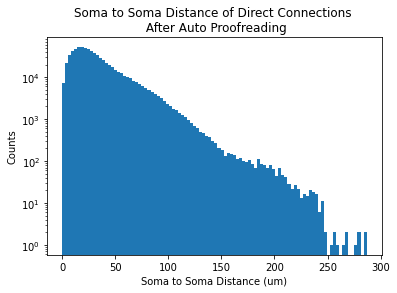

In [37]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots(1,1)
ax.hist(total_distances_no_self_loops_auto/1000,bins=100,density=False)
ax.set_title("Soma to Soma Distance of Direct Connections \n After Auto Proofreading")
ax.set_xlabel("Soma to Soma Distance (um)")
ax.set_ylabel("Counts")
plt.yscale("log")
plt.xscale("linear")
plt.show()

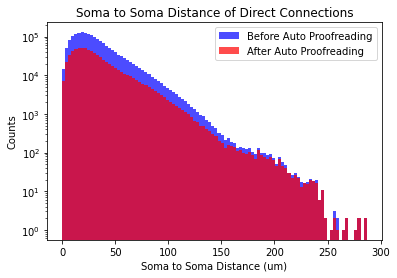

In [43]:
alpha_level = 0.7

import matplotlib.pyplot as plt
fig,ax = plt.subplots(1,1)
ax.hist(total_distances_no_self_loops/1000,bins=100,density=False,color="blue",label="Before Auto Proofreading",alpha=alpha_level)
ax.hist(total_distances_no_self_loops_auto/1000,bins=100,density=False,color="red",label="After Auto Proofreading",alpha=alpha_level)
ax.set_title("Soma to Soma Distance of Direct Connections")
ax.set_xlabel("Soma to Soma Distance (um)")
ax.set_ylabel("Counts")

ax.set_yscale("log")
ax.set_xscale("linear")
ax.legend()
plt.show()